# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [246]:
# import libraries
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler #used because won't distort binary vars
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [247]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Identify Features") \
    .getOrCreate()
df = spark.read.json('mini_sparkify_event_data.json')

In [248]:
# Print columns for future reference
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [249]:
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [250]:
# Tabulated head through pandas
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [251]:
def clean_data(df):
    """
    Removes special characters from StringType columns 
    create function to format ts and add 3 new columns with timestamptype and datetype,
    Extracts month from date
    Extracts year from date
    Remove user id null
    Remove session id null
    Splits location field and takes only state name as location
    :param df: Spark DataFrame
    :return df preprocessed Spark DataFrame
    """
    # cleanse stringtype fields from special characters
    for key, dtype in df.dtypes:
        if dtype=='string':
            df = df.withColumn(key, regexp_replace(key, '[^a-zA-Z0-9\,\-]', '')) 
    
    # Create a user defined function for formating the timestamp
    get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

    #Apply the udf on the ts column
    df = df.withColumn("time", get_time(df.ts))
    df = df.withColumn("session_date", to_date(col("time"),"yyyy-MM-dd"))
    df = df.withColumn("session_month", month(col('session_date')))
    df = df.withColumn("session_year", year(col('session_date')))

    # remove user id null
    df = df[df.userId != ""]
    # remove session id null    
#     df = df[df.sessionId != ""]    

    # replace location with extracting state from it
    df = df.withColumn('location', split(col('location'),',').getItem(1))
   
    return df

In [252]:
df=clean_data(df)
df.head(2)

[Row(artist='MarthaTilston', auth='LoggedIn', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla50WindowsNT61WOW64rv310Gecko20100101Firefox310', userId='30', time='2018-10-01 00:01:57', session_date=datetime.date(2018, 10, 1), session_month=10, session_year=2018),
 Row(artist='FiveIronFrenzy', auth='LoggedIn', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML,likeGeckoChrome3702062103Safari53736', userId='9', time='2018-10-01 00:03:00', session_date=datetime.date(2018, 10, 1), session_month=10, session_year=2018)]

In [253]:
dfp = df.toPandas()
dfp.head()



,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,time,session_date,session_month,session_year
0,MarthaTilston,LoggedIn,Colin,M,50,Freeman,277.89016,paid,CA,PUT,...,29,Rockpools,200,1538352117000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,30,2018-10-01 00:01:57,2018-10-01,10,2018
1,FiveIronFrenzy,LoggedIn,Micah,M,79,Long,236.09424,free,MA-NH,PUT,...,8,Canada,200,1538352180000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:03:00,2018-10-01,10,2018
2,AdamLambert,LoggedIn,Colin,M,51,Freeman,282.82730,paid,CA,PUT,...,29,TimeForMiracles,200,1538352394000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,30,2018-10-01 00:06:34,2018-10-01,10,2018
3,Enigma,LoggedIn,Micah,M,80,Long,262.71302,free,MA-NH,PUT,...,8,KnockingOnForbiddenDoors,200,1538352416000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:06:56,2018-10-01,10,2018
4,DaftPunk,LoggedIn,Colin,M,52,Freeman,223.60771,paid,CA,PUT,...,29,HarderBetterFasterStronger,200,1538352676000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,30,2018-10-01 00:11:16,2018-10-01,10,2018


In [254]:
df.count()

278154

In [255]:
def load_data(df):
    """
    Add churn column
    :param df: spark DataFrame
    """
    # define churn column
    churn = udf(lambda x: 1 if ((x=='CancellationConfirmation')) else 0, IntegerType())
    df = df.withColumn("churn", churn("page"))


    return df    

In [256]:
df=load_data(df)

In [257]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- session_date: date (nullable = true)
 |-- session_month: integer (nullable = true)
 |-- session_year: integer (nullable = true)
 |-- churn: integer (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [258]:
#try sparksql
#Create a temporary view to perform SQL operations
df.createOrReplaceTempView("user_table")

In [259]:
spark.sql('''
        SELECT page,COUNT(distinct userId) AS user_counts
        FROM user_table
        GROUP BY page
        ORDER BY user_counts DESC
''').show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|        225|
|                Home|        223|
|            ThumbsUp|        220|
|       AddtoPlaylist|        215|
|              Logout|        213|
|          RollAdvert|        207|
|           AddFriend|        206|
|          ThumbsDown|        203|
|            Settings|        195|
|                Help|        192|
|             Upgrade|        168|
|               About|        155|
|           Downgrade|        154|
|        SaveSettings|        132|
|       SubmitUpgrade|        131|
|               Error|        117|
|CancellationConfi...|         52|
|              Cancel|         52|
|     SubmitDowngrade|         49|
+--------------------+-----------+



In [260]:
# % users have churned.
avg_churn = spark.sql('''
        SELECT round((sum(churn)/count(distinct userId))*100,1) percentage_churn
        FROM user_table
''')

avg_churn.show()

+----------------+
|percentage_churn|
+----------------+
|            23.1|
+----------------+



23.1% of the users are churned

In [261]:
artist_count = spark.sql('''
        SELECT artist,  count(distinct userId) number_users
        FROM user_table
        group by artist
        order by 2 desc
''')

artist_count.show()

+------------------+------------+
|            artist|number_users|
+------------------+------------+
|              null|         224|
|       KingsOfLeon|         199|
|          Coldplay|         189|
|      DwightYoakam|         189|
|FlorenceTheMachine|         187|
|      TheBlackKeys|         179|
|              Bjrk|         179|
|      JustinBieber|         177|
|       JackJohnson|         173|
|       TaylorSwift|         173|
|          Harmonia|         172|
|    AllianceEthnik|         172|
|        GunsNRoses|         170|
|             Train|         169|
|            Eminem|         169|
|        TheKillers|         168|
|         Metallica|         168|
|       OneRepublic|         168|
|         Radiohead|         167|
|         JohnMayer|         166|
+------------------+------------+
only showing top 20 rows



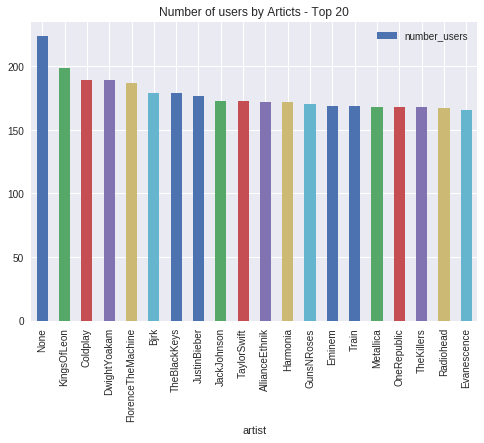

In [262]:
artist_count_df=artist_count.toPandas().head(20)
artist_count_df.plot(kind='bar',x='artist',y='number_users')
plt.style.use("seaborn")
plt.title("Number of users by Articts - Top 20");

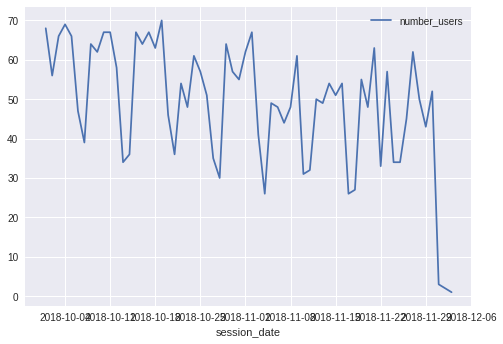

In [263]:
avg_daily_sessions = spark.sql('''
        SELECT session_date, count(distinct userId) number_users
        FROM user_table
        group by 1
''')

dfp = avg_daily_sessions.toPandas()
dfp.head()

import matplotlib.pyplot as plt
 
# Using a inbuilt style to change
# the look and feel of the plot

plt.style.use("seaborn")
dfp.plot(x='session_date', y='number_users')


Text(0.5,0,'Events')

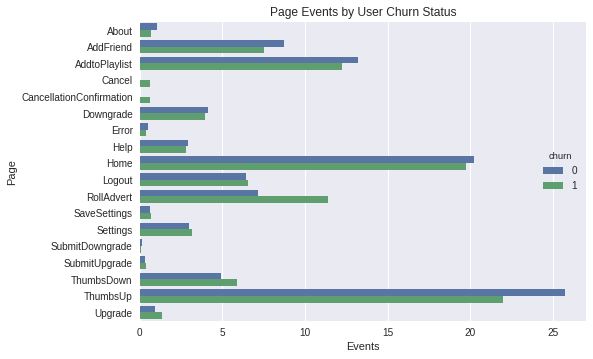

In [264]:
import seaborn as sns
window_churn = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_churn = df.withColumn('churn',max('churn').over(window_churn))

# plot churn by page event
df_pages = df_churn.groupby(['page','churn']).count().toPandas()
df_pages = df_pages[df_pages['page'] != 'NextSong']
df_pages = ((df_pages.groupby(['page','churn']).sum() / df_pages.groupby(['churn']).sum()) *100).reset_index()
sns.barplot(y = 'page', x = 'count', data = df_pages, hue = 'churn')
plt.title("Page Events by User Churn Status")
plt.ylabel('Page')
plt.xlabel('Events')

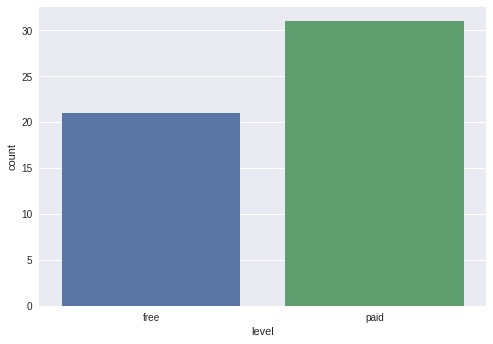

In [265]:
# plot churn by account level
df_level = df_churn.filter('page == "CancellationConfirmation"').groupby('level').count().toPandas()
sns.barplot(x = 'level', y = 'count', data = df_level)

In [266]:
song_count = spark.sql('''
            SELECT userId,  count(distinct song) songs
            FROM user_table
            group by userId
            order by 2 desc
''')

song_count.show()

+------+-----+
|userId|songs|
+------+-----+
|    39| 5936|
|    92| 4619|
|   140| 4423|
|300011| 3700|
|   124| 3339|
|300021| 3194|
|    85| 3066|
|300017| 3012|
|    42| 2960|
|     6| 2677|
|    29| 2561|
|200023| 2513|
|    54| 2414|
|   100| 2302|
|     9| 2297|
|   126| 2226|
|    91| 2217|
|300015| 2169|
|    98| 2095|
|    74| 2069|
+------+-----+
only showing top 20 rows



In [ ]:
def avg_songs(viewname):
    """
    Calculates daily and monthly average of distinct song for each user
    :param df:spark DataFrame
    :return daily and monthly aggregates DataFrame
    
    """    
    
    tablename=viewname
    sql_daily_songs='''
            SELECT userId, session_date, count(distinct song) daily_song
            FROM {0}
            group by userId, session_date
    '''.format(tablename)    
    avg_daily_songs=spark.sql(sql_daily_songs)
    avg_daily_songs=avg_daily_songs.groupBy('userId').avg('daily_song').\
    withColumnRenamed('avg(daily_song)', 'avg_daily_songs')
    
    sql_monthly_songs='''
            SELECT userId, session_month, count(distinct song) monthly_songs
            FROM {0}
            group by userId, session_month
    '''.format(tablename)
    avg_monthly_songs= spark.sql(sql_monthly_songs)
    avg_monthly_songs=avg_monthly_songs.groupBy('userId').avg('monthly_songs').\
    withColumnRenamed('avg(monthly_songs)', 'avg_monthly_songs')

    return avg_daily_songs.join(avg_monthly_songs, on='userId')

In [ ]:
def avg_sessions(viewname):
    """
    Calculates daily and monthly average of distinct sessionId for each user
    :param df:spark DataFrame
    :return daily and monthly aggregates DataFrame
    
    """    
    
    tablename=viewname
    sql_daily_sessions='''
            SELECT userId, session_date, count(distinct sessionId) daily_sessions
            FROM {0}
            group by userId, session_date
    '''.format(tablename)    
    avg_daily_sessions=spark.sql(sql_daily_sessions)
    avg_daily_sessions=avg_daily_sessions.groupBy('userId').avg('daily_sessions').\
    withColumnRenamed('avg(daily_sessions)', 'avg_daily_sessions')
    
    sql_sessions_monthly='''
            SELECT userId, session_month, count(distinct sessionId) monthly_sessions
            FROM {0}
            group by userId, session_month
    '''.format(tablename)
    avg_monthly_sessions= spark.sql(sql_sessions_monthly)
    avg_monthly_sessions=avg_monthly_sessions.groupBy('userId').avg('monthly_sessions').\
    withColumnRenamed('avg(monthly_sessions)', 'avg_monthly_sessions')

    return avg_daily_sessions.join(avg_monthly_sessions, on='userId')

In [ ]:
def avg_session_duration(viewname):
    """
    Calculates daily and monthly average of distinct sessionId dureation for each user
    :param df:spark DataFrame
    :return daily and monthly aggregates DataFrame
    """
    tablename=viewname
    sql_session_duration = '''
            SELECT userId,  session_month, session_date, sessionId,  min(time) session_start, max(time) session_end 
            FROM {0}
            group by userId, session_month, session_date, sessionId
            order by userId, session_month, session_date, sessionId
    '''.format(tablename)  
    session_duration_df=spark.sql(sql_session_duration)
    session_duration_df=session_duration_df.withColumn('session_start',to_timestamp(col('session_start')))\
      .withColumn('session_end', to_timestamp(col('session_end')))\
      .withColumn('session_duration',col("session_end").cast("long") - col('session_start').cast("long"))\
  
    
    # avg daily sessions
    avg_daily_sessions_duration = session_duration_df.groupBy('userId', 'session_date').agg(avg('session_duration').alias("avg_daily_sessions_duration")).\
    groupby('userId').\
    agg(mean('avg_daily_sessions_duration').alias('avg_daily_sessions_duration')).\
    orderBy('userId', ascending=False)
    
    # avg monthly sessions
    avg_monthly_sessions_duration = session_duration_df.groupBy('userId', 'session_month').agg(avg('session_duration').alias("avg_monthly_sessions_duration")).\
    groupby('userId').\
    agg(mean('avg_monthly_sessions_duration').alias('avg_monthly_sessions_duration')).\
    orderBy('userId', ascending=False)
    
    return avg_daily_sessions_duration.join(avg_monthly_sessions_duration, on='userId')    

In [ ]:
def agg_page(df):
    """
    Calculates monthly, daily averages for each user,for each page event except the ones that include "cancel" 
    :param df: spark DataFrame
    :return daily and monthly aggregates DataFrame
    """
    # monthly
    monthly_page_event_df = df.groupby('userId','session_month').pivot('page').count().fillna(0)
    monthly_page_event_df = monthly_page_event_df.drop('Cancel','CancellationConfirmation').drop_duplicates()

    exprs = {x: "mean" for x in monthly_page_event_df.columns}
    del exprs['userId']
    del exprs['session_month']

    monthly_page_event_df = monthly_page_event_df.groupBy('userId').agg(exprs).fillna(0)

    for col in exprs.keys():
        monthly_page_event_df = monthly_page_event_df.withColumnRenamed('avg({})'.format(col), 'avg_monthly_{}'.format(col))

    # daily
    daily_page_event_df = df.groupby('userId','session_date').pivot('page').count().fillna(0)
    daily_page_event_df = daily_page_event_df.drop('Cancel','CancellationConfirmation').drop_duplicates()

    exprs_daily = {x: "mean" for x in daily_page_event_df.columns}
    del exprs_daily['userId']
    del exprs_daily['session_date']

    daily_page_event_df = daily_page_event_df.groupBy('userId').agg(exprs_daily).fillna(0)

    for col in exprs_daily.keys():
        daily_page_event_df = daily_page_event_df.withColumnRenamed('avg({})'.format(col), 'avg_daily_{}'.format(col))   

    return daily_page_event_df.join(monthly_page_event_df, on='userId')



In [ ]:
import pyspark.sql.functions as F
def agg_level(df):
    '''
    calculate last level
    '''
    
    level_df =df.select("userId","level", F.row_number().over(Window.partitionBy(df['userId']).orderBy(df['ts'])).alias("row_num"))
    level_df=level_df.filter('row_num == 1')
    
    level_df = level_df.drop('row_num')
     
    return level_df

In [ ]:
def agg_features(viewname):
    '''
    join all non numerical features together and the account lifetime
    '''
    
    tablename=viewname
    sql_features = '''
          SELECT  
          userId,  
          max(churn) churn,
          gender,
          coalesce(MAX(ts - registration),0) AS account_lifetime
          FROM {0}
          GROUP BY userId,gender
    '''.format(tablename)  
    mum_features_df=spark.sql(sql_features)
     
    return mum_features_df

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
features_df=agg_features("user_table")
agg_page_df=agg_page(df)
agg_last_level_df = agg_level(df)
avg_session_duration_df=avg_session_duration("user_table")
avg_sessions_df=avg_sessions("user_table")
avg_songs_df=avg_songs("user_table")

In [ ]:
dataset=features_df.join(agg_page_df,on='userId',how='inner').\
                    join(avg_session_duration_df,on='userId',how='inner').\
                    join(avg_sessions_df,on='userId',how='inner').\
                    join(agg_last_level_df,on='userId',how='inner').\
                    join(avg_songs_df,on='userId',how='inner')
# dataset.show()

In [221]:
dataset=dataset.drop('userId')
dataset=dataset.drop_duplicates()

In [222]:
pd.DataFrame(dataset.take(5), columns=dataset.columns).head()

,churn,gender,account_lifetime,avg_daily_RollAdvert,avg_daily_Settings,avg_daily_Downgrade,avg_daily_NextSong,avg_daily_Error,avg_daily_About,avg_daily_Upgrade,...,avg_monthly_SubmitUpgrade,avg_monthly_Help,avg_monthly_SubmitDowngrade,avg_daily_sessions_duration,avg_monthly_sessions_duration,avg_daily_sessions,avg_monthly_sessions,level,avg_daily_songs,avg_monthly_songs
0,0,M,8548746000,3.000000,0.000000,0.000000,32.666667,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,8058.333333,7533.000000,1.000000,1.5,free,32.666667,49.0
1,0,M,10710547000,2.125000,0.250000,0.000000,22.250000,0.000000,0.000000,0.375000,...,0.0,0.5,0.0,5975.187500,6251.175000,1.125000,4.5,free,22.250000,89.0
2,0,F,10754921000,2.437500,0.375000,0.312500,40.437500,0.062500,0.437500,0.562500,...,1.0,1.5,0.5,9026.156250,9786.807143,1.062500,8.0,free,40.062500,314.0
3,0,M,5485478000,0.136364,0.636364,1.000000,85.227273,0.227273,0.045455,0.045455,...,0.5,7.5,0.0,20254.840909,20648.515152,1.045455,8.0,free,83.818182,870.5
4,1,F,9568946000,1.516129,0.548387,1.258065,91.645161,0.032258,0.161290,0.032258,...,0.5,8.5,0.5,16431.435484,14231.790196,1.580645,19.0,paid,90.516129,1273.5


In [223]:
dataset_pd = dataset.toPandas()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


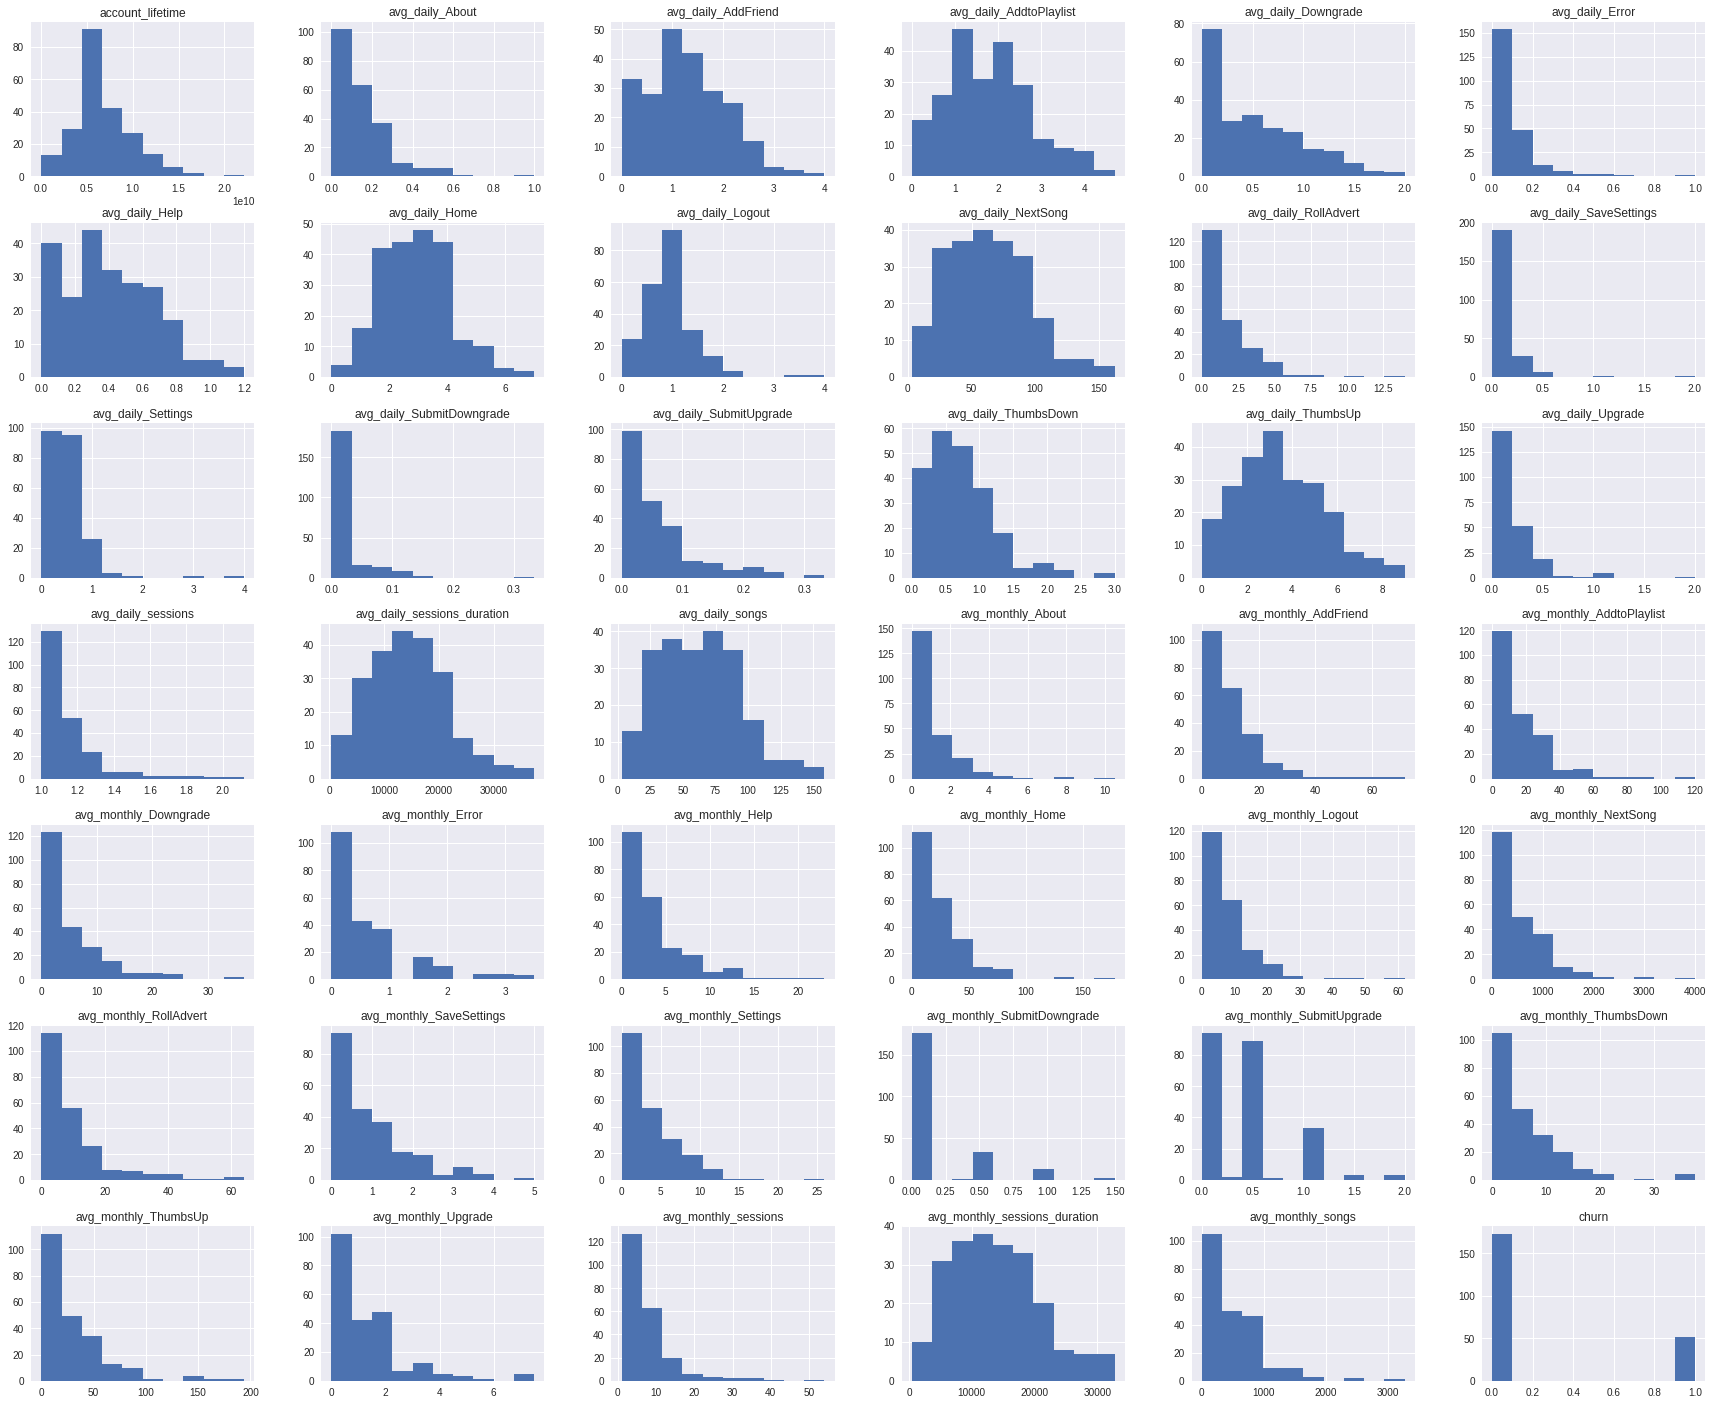

In [224]:
graph = plt.figure(figsize=(30,25))
ax = graph.gca()
hist = dataset_pd.hist(ax=ax)

In [ ]:
Most of the features are skewed to the left, normalization might be required, unless a model such as Random Forest which is insensitive to imbalance is used.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [225]:
def build_model(df):
    # Rename churn column into label
    df = df.withColumn('label', df['churn'].cast('float')).drop('churn') #important to have float type

    # Feature columns to be converted into vector
    feature_cols = df.drop('label').drop('gender').drop('level').drop('userId').columns
    
    index_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
    index_level = StringIndexer(inputCol='level', outputCol='level_index')
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

    pipeline = Pipeline(stages=[index_gender, index_level, assembler])

    model_df =pipeline.fit(df).transform(df)
    
    return model_df


In [226]:
# source: https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python
def calc_metrics(model, test):

    # Create both evaluators
    eval_Multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')

    # Make predicitons
    prediction = model.transform(test).select('label', 'prediction')

    # Get metrics
    accuracy = eval_Multi.evaluate(prediction, {eval_Multi.metricName: 'accuracy'})
    f1 = eval_Multi.evaluate(prediction, {eval_Multi.metricName: 'f1'})
    weightedPrecision = eval_Multi.evaluate(prediction, {eval_Multi.metricName: 'weightedPrecision'})
    weightedRecall = eval_Multi.evaluate(prediction, {eval_Multi.metricName: 'weightedRecall'})
    auc = evaluator.evaluate(prediction)
    

    metrics = pd.DataFrame(index=['F1', 'accuracy', 'weighted precision', 'weighted recall', 'AUC'], \
                           data={'metrics value': [f1, accuracy, weightedPrecision, weightedRecall, auc]})

    return metrics

In [227]:
model_df=build_model(dataset)

In [228]:
model_df_pd=model_df.toPandas()

In [229]:
model_df_pd

,gender,account_lifetime,avg_daily_RollAdvert,avg_daily_Settings,avg_daily_Downgrade,avg_daily_NextSong,avg_daily_Error,avg_daily_About,avg_daily_Upgrade,avg_daily_Home,...,avg_monthly_sessions_duration,avg_daily_sessions,avg_monthly_sessions,level,avg_daily_songs,avg_monthly_songs,label,gender_index,level_index,features
0,M,8548746000,3.000000,0.000000,0.000000,32.666667,0.000000,0.000000,0.000000,2.000000,...,7533.000000,1.000000,1.500000,free,32.666667,49.000000,0.0,0.0,0.0,"(8548746000.0, 3.0, 0.0, 0.0, 32.6666666667, 0..."
1,M,10710547000,2.125000,0.250000,0.000000,22.250000,0.000000,0.000000,0.375000,1.500000,...,6251.175000,1.125000,4.500000,free,22.250000,89.000000,0.0,0.0,0.0,"[10710547000.0, 2.125, 0.25, 0.0, 22.25, 0.0, ..."
2,F,10754921000,2.437500,0.375000,0.312500,40.437500,0.062500,0.437500,0.562500,2.312500,...,9786.807143,1.062500,8.000000,free,40.062500,314.000000,0.0,1.0,0.0,"[10754921000.0, 2.4375, 0.375, 0.3125, 40.4375..."
3,M,5485478000,0.136364,0.636364,1.000000,85.227273,0.227273,0.045455,0.045455,3.454545,...,20648.515152,1.045455,8.000000,free,83.818182,870.500000,0.0,0.0,0.0,"[5485478000.0, 0.136363636364, 0.636363636364,..."
4,F,9568946000,1.516129,0.548387,1.258065,91.645161,0.032258,0.161290,0.032258,4.161290,...,14231.790196,1.580645,19.000000,paid,90.516129,1273.500000,1.0,1.0,1.0,"[9568946000.0, 1.51612903226, 0.548387096774, ..."
5,M,6649256000,2.000000,0.333333,0.333333,32.133333,0.000000,0.133333,0.400000,2.066667,...,8161.035714,1.000000,7.500000,free,32.000000,233.500000,0.0,0.0,0.0,"[6649256000.0, 2.0, 0.333333333333, 0.33333333..."
6,F,13864787000,0.600000,0.000000,0.400000,39.000000,0.000000,0.000000,0.000000,1.200000,...,5448.777778,1.000000,1.333333,paid,39.000000,64.333333,0.0,1.0,1.0,"(13864787000.0, 0.6, 0.0, 0.4, 39.0, 0.0, 0.0,..."
7,F,6412544000,3.800000,0.200000,0.000000,49.200000,0.000000,0.000000,0.800000,2.200000,...,11745.750000,1.000000,2.000000,free,48.600000,120.000000,0.0,1.0,0.0,"[6412544000.0, 3.8, 0.2, 0.0, 49.2, 0.0, 0.0, ..."
8,F,1131755000,0.571429,0.714286,1.714286,132.428571,0.000000,0.285714,0.571429,4.285714,...,25175.100000,1.428571,7.000000,free,130.571429,875.000000,1.0,1.0,0.0,"[1131755000.0, 0.571428571429, 0.714285714286,..."
9,M,14073918000,0.083333,0.916667,1.333333,104.750000,0.083333,0.083333,0.000000,5.000000,...,17553.233333,1.333333,6.000000,paid,102.916667,589.000000,0.0,0.0,1.0,"[14073918000.0, 0.0833333333333, 0.91666666666..."


In [231]:
train, validation = model_df.randomSplit([0.8, 0.2], seed=42)

# The Logistic Regression model

In [180]:
lr = LogisticRegression()#(maxIter=10)
lrModel = lr.fit(train)

In [181]:
metrics =calc_metrics(lrModel, validation)

In [182]:
metrics

,metrics value
F1,0.663687
accuracy,0.676471
weighted precision,0.661961
weighted recall,0.676471
AUC,0.617424


# RandomForestClassifier Model


In [232]:
rf = RandomForestClassifier()
rfModel = rf.fit(train)

In [233]:
metrics =calc_metrics(rfModel,validation)

In [234]:
metrics

,metrics value
F1,0.797521
accuracy,0.840909
weighted precision,0.867424
weighted recall,0.840909
AUC,0.611111


In [235]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20,75]) \
    .addGrid(rf.maxDepth,[10,20]) \
    .build()

In [236]:
model_evaluator_rf = CrossValidator(
                    estimator=Pipeline(stages=[rf]),
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                    numFolds=3)

In [237]:
cv_rf= model_evaluator_rf.fit(train)
# prediction = cv_rf.transform(validation)

In [238]:
prediction = cv_rf.transform(validation)

In [239]:
feature_coeff = cv_rf.bestModel.stages[-1]

In [240]:
# feature_cols = dataset.drop('label').drop('churn').drop('level').columns
columns_md=[]
for i in range(len(feature_coeff.featureImportances)):
    columns_md.append(model_df.columns[i])

In [241]:
columns_md

['gender',
 'account_lifetime',
 'avg_daily_RollAdvert',
 'avg_daily_Settings',
 'avg_daily_Downgrade',
 'avg_daily_NextSong',
 'avg_daily_Error',
 'avg_daily_About',
 'avg_daily_Upgrade',
 'avg_daily_Home',
 'avg_daily_Logout',
 'avg_daily_AddtoPlaylist',
 'avg_daily_ThumbsDown',
 'avg_daily_ThumbsUp',
 'avg_daily_SaveSettings',
 'avg_daily_AddFriend',
 'avg_daily_SubmitUpgrade',
 'avg_daily_Help',
 'avg_daily_SubmitDowngrade',
 'avg_monthly_RollAdvert',
 'avg_monthly_Settings',
 'avg_monthly_Downgrade',
 'avg_monthly_NextSong',
 'avg_monthly_Error',
 'avg_monthly_About',
 'avg_monthly_Upgrade',
 'avg_monthly_Home',
 'avg_monthly_Logout',
 'avg_monthly_AddtoPlaylist',
 'avg_monthly_ThumbsDown',
 'avg_monthly_ThumbsUp',
 'avg_monthly_SaveSettings',
 'avg_monthly_AddFriend',
 'avg_monthly_SubmitUpgrade',
 'avg_monthly_Help',
 'avg_monthly_SubmitDowngrade',
 'avg_daily_sessions_duration',
 'avg_monthly_sessions_duration',
 'avg_daily_sessions',
 'avg_monthly_sessions',
 'level']

In [243]:
for i in range(len(bestPipeline.featureImportances)):
    print("{} : {} \n".format(model_df.columns[i], feature_coeff.featureImportances[i]))

print('Best parameters : max depth:{}, num Trees:{}'.\
      format(bestPipeline.getOrDefault('maxDepth'), feature_coeff.getNumTrees))

gender : 0.15918573817904133 

account_lifetime : 0.043203355573256 

avg_daily_RollAdvert : 0.023872352555876417 

avg_daily_Settings : 0.010489021055798393 

avg_daily_Downgrade : 0.011907551589511728 

avg_daily_NextSong : 0.013041890409287127 

avg_daily_Error : 0.011560132069895057 

avg_daily_About : 0.017829011349609177 

avg_daily_Upgrade : 0.032087673348900565 

avg_daily_Home : 0.03317086740567491 

avg_daily_Logout : 0.024644390722150432 

avg_daily_AddtoPlaylist : 0.06287836865232009 

avg_daily_ThumbsDown : 0.032761579787861324 

avg_daily_ThumbsUp : 0.013951576685036497 

avg_daily_SaveSettings : 0.03192206073440541 

avg_daily_AddFriend : 0.016400967647334865 

avg_daily_SubmitUpgrade : 0.019307168342140565 

avg_daily_Help : 0.006683796654757048 

avg_daily_SubmitDowngrade : 0.024531826275335504 

avg_monthly_RollAdvert : 0.019581211818916443 

avg_monthly_Settings : 0.014149791747731516 

avg_monthly_Downgrade : 0.013426545499649481 

avg_monthly_NextSong : 0.011446460

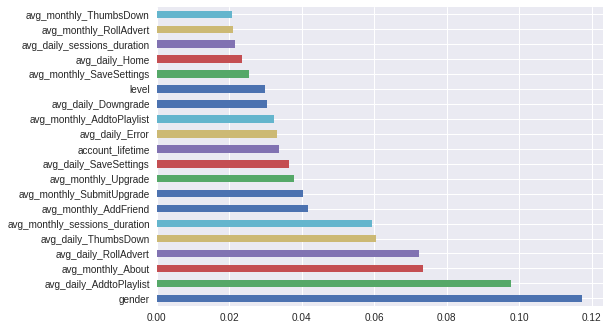

In [244]:
feat_importances = pd.Series(bestPipeline.featureImportances, index=columns_md)
feat_importances.nlargest(20).plot(kind='barh')

# GBTClassifier Model

In [195]:
gbt = GBTClassifier()
gbtModel = gbt.fit(train)


In [196]:
metrics =calc_metrics(gbtModel,validation)

In [197]:
metrics

,metrics value
F1,0.724835
accuracy,0.735294
weighted precision,0.727059
weighted recall,0.735294
AUC,0.681818


# LinearSVC Model

In [198]:
scv = LinearSVC()
scvModel = scv.fit(train)

In [199]:
metrics =calc_metrics(scvModel,validation)
metrics

,metrics value
F1,0.698962
accuracy,0.735294
weighted precision,0.750913
weighted recall,0.735294
AUC,0.643939


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# Conclusion
The machine learning modeling do well in predicting the churn of the customers' activity that will most probably end in churned customers. Even with the good results of all the models, the Decision Tree Classifier model looks to be the best here. However, the other models need to be altered using different settings to decrease the misclassified.

How to improve the current implementation?
Regarless of the results achive from the development, it is possible to get better the results by doing some extra changes as per below:

1- Working with more data with larger dataset size (working with 12GB full dataset)

2- Adding more parameters of the selected models.

3- Adding some more features, like the customer location (city/state). The customers churn om some states seem to be more higher than others; this might be associated with customer behaviour and lifestyle profiles force people to be rapidly bored, and thus they like to change to the competititors.